In [50]:
# Importing the required libraries
import pandas as pd
import kagglehub
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# To download the latest version of the dataset from Kaggle Hub
file_path = kagglehub.dataset_download("miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests")
print("Path to our dataset files:", file_path)
df = pd.read_csv(file_path + "/analyst_ratings_processed.csv")

Path to our dataset files: /Users/andre/.cache/kagglehub/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests/versions/2


In [51]:
# Data Preprocessing
# Filter the DataFrame to include only the selected stocks
df = df[df['stock'].isin(['NVDA', 'MRK','MS','MU'])]
# Dropping missing/null values
df = df.dropna(subset=["date"])
df = df.dropna(subset=["stock"])
# Converting the 'date' column to datetime format with UTC timezone to standerize time
df['date'] = pd.to_datetime(df['date'], utc=True)
date_threshold = pd.to_datetime('2020-01-01', utc=True)
# Keeping only rows where the 'date' is before January 1, 2020
df = df[df['date'] < date_threshold]
# Printing the head to ensure the datset looks correct
print(df.head())

        Unnamed: 0                                              title  \
839155    850907.0  Merck-AstraZeneca's Lynparza Snags FDA Nod For...   
839156    850908.0  Merck's LYNPARZA Approved By FDA As First-Line...   
839157    850909.0  AstraZeneca Says FDA Approved Lynparza for Pan...   
839158    850910.0  Week Ahead In Biotech: PDUFA Date Ahead For As...   
839159    850911.0  Merck & Co Option Alert: Jun 19 $92.5 Calls Sw...   

                            date stock  
839155 2019-12-30 16:41:00+00:00   MRK  
839156 2019-12-30 11:55:00+00:00   MRK  
839157 2019-12-30 10:27:00+00:00   MRK  
839158 2019-12-29 23:38:00+00:00   MRK  
839159 2019-12-27 17:23:00+00:00   MRK  


In [52]:
# Process to add the stock prices to original datset
# List of stocks we picked and their corresponding .csv files
stock_files = {
    'NVDA': 'NVDA.csv'
    ,'MRK': 'MRK.csv'
    ,'MS': 'MS.csv'
    ,'MU': 'MU.csv'
}

stock_dfs = []
# Loop through each stock ticker and it's corresponding CSV file
for ticker, file_path in stock_files.items():
    stock_data = pd.read_csv(file_path)
    # Add a column to identify the stock in the data
    stock_data['stock'] = ticker
    # Add the DataFrame to the list
    stock_dfs.append(stock_data)

# Combine all stock DataFrames into a single DataFrame
combined_stock_data = pd.concat(stock_dfs, ignore_index=True)

# Converting the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Converting the 'date' column of the new df to datetime format
combined_stock_data['Date'] = pd.to_datetime(combined_stock_data['Date'])

# Create a new column with just the date (no time) in the stock data
df['date_only'] = df['date'].dt.date

# No time required so we create a new column with just the date
combined_stock_data['date_only'] = combined_stock_data['Date'].dt.date

# Merge stock price data on date and stock symbol using exisitng and new df
df = pd.merge(
    df,
    combined_stock_data[['date_only', 'stock', 'Open', 'Close']],
    how='left',
    on=['date_only', 'stock']
)

# Drop the temporary 'date_only' column after merging
df = df.drop(columns=['date_only'])

# Printing the head to ensure the datset looks correct
print(df.head())

   Unnamed: 0                                              title  \
0    850907.0  Merck-AstraZeneca's Lynparza Snags FDA Nod For...   
1    850908.0  Merck's LYNPARZA Approved By FDA As First-Line...   
2    850909.0  AstraZeneca Says FDA Approved Lynparza for Pan...   
3    850910.0  Week Ahead In Biotech: PDUFA Date Ahead For As...   
4    850911.0  Merck & Co Option Alert: Jun 19 $92.5 Calls Sw...   

                       date stock       Open      Close  
0 2019-12-30 16:41:00+00:00   MRK  91.529999  91.029999  
1 2019-12-30 11:55:00+00:00   MRK  91.529999  91.029999  
2 2019-12-30 10:27:00+00:00   MRK  91.529999  91.029999  
3 2019-12-29 23:38:00+00:00   MRK        NaN        NaN  
4 2019-12-27 17:23:00+00:00   MRK  91.680000  91.500000  


In [53]:
df

,Unnamed: 0,title,date,stock,Open,Close
0,850907.0,Merck-AstraZeneca's Lynparza Snags FDA Nod For...,2019-12-30 16:41:00+00:00,MRK,91.529999,91.029999
1,850908.0,Merck's LYNPARZA Approved By FDA As First-Line...,2019-12-30 11:55:00+00:00,MRK,91.529999,91.029999
2,850909.0,AstraZeneca Says FDA Approved Lynparza for Pan...,2019-12-30 10:27:00+00:00,MRK,91.529999,91.029999
3,850910.0,Week Ahead In Biotech: PDUFA Date Ahead For As...,2019-12-29 23:38:00+00:00,MRK,NaN,NaN
4,850911.0,Merck & Co Option Alert: Jun 19 $92.5 Calls Sw...,2019-12-27 17:23:00+00:00,MRK,91.680000,91.500000
...,...,...,...,...,...,...
11932,932184.0,J.P. Morgan Upgrades NVIDIA Corporation To Neu...,2011-03-08 12:59:00+00:00,NVDA,20.690001,19.549999
11933,932185.0,"JP Morgan Upgrades NVIDIA To Neutral, $21 PT",2011-03-08 12:24:00+00:00,NVDA,20.690001,19.549999
11934,932186.0,Goldman Sachs Gives Color On Semiconductors (N...,2011-03-07 13:23:00+00:00,NVDA,20.910000,20.469999
11935,932187.0,Auriga Still Not Sure Where Reality Lies For N...,2011-03-07 12:47:00+00:00,NVDA,20.910000,20.469999


In [54]:
# To see the stats of our DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11937 entries, 0 to 11936
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Unnamed: 0  11937 non-null  float64            
 1   title       11937 non-null  object             
 2   date        11937 non-null  datetime64[ns, UTC]
 3   stock       11937 non-null  object             
 4   Open        11565 non-null  float64            
 5   Close       11565 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3), object(2)
memory usage: 559.7+ KB


In [55]:
# Load the FinBERT tokenizer to convert headlines into token IDs
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Load the FinBERT sequence‐classification model for sentiment scoring
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [56]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Custom dataset for batching
class HeadlineDataset(Dataset):
    def __init__(self, headlines):
        self.headlines = headlines

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        return self.headlines[idx]

# Batch processing function
def get_sentiment_scores_batch(headlines, batch_size=32):
    dataset = HeadlineDataset(headlines)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_scores = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for speed
        for batch in dataloader:
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy()  # Move back to CPU for NumPy
            # Compute scores for the batch
            scores = (logits[:, 0] * -1 + logits[:, 2] * 1) / (logits[:, 0] + logits[:, 1] + logits[:, 2])
            all_scores.extend(scores)

    return np.array(all_scores)

# Apply to DataFrame
df['finbert_sentiment_score'] = get_sentiment_scores_batch(df['title'].tolist())

In [57]:
def test_scale_sentiment():
    assert scale_sentiment(p1, p1, p99) == -1
    assert scale_sentiment(p99, p1, p99) == 1
    assert scale_sentiment((p1+p99)/2, p1, p99) == 0

def test_headline_dataset():
    ds = HeadlineDataset(["foo","bar"])
    assert len(ds)==2
    assert ds[1]=="bar"

def test_get_sentiment_scores_batch(monkeypatch):
    # stub tokenizer/model to always return logits [[1,0,1]]
    class StubModel: ...
    monkeypatch.setattr(model_module, "model", StubModel())
    monkeypatch.setattr(model_module, "tokenizer", StubTokenizer())
    arr = get_sentiment_scores_batch(["x","y"], batch_size=1)
    assert isinstance(arr, np.ndarray)
    assert arr.shape == (2,)

In [58]:
df

,Unnamed: 0,title,date,stock,Open,Close,finbert_sentiment_score
0,850907.0,Merck-AstraZeneca's Lynparza Snags FDA Nod For...,2019-12-30 16:41:00+00:00,MRK,91.529999,91.029999,-3.681350
1,850908.0,Merck's LYNPARZA Approved By FDA As First-Line...,2019-12-30 11:55:00+00:00,MRK,91.529999,91.029999,2.896242
2,850909.0,AstraZeneca Says FDA Approved Lynparza for Pan...,2019-12-30 10:27:00+00:00,MRK,91.529999,91.029999,3.061872
3,850910.0,Week Ahead In Biotech: PDUFA Date Ahead For As...,2019-12-29 23:38:00+00:00,MRK,NaN,NaN,9.788986
4,850911.0,Merck & Co Option Alert: Jun 19 $92.5 Calls Sw...,2019-12-27 17:23:00+00:00,MRK,91.680000,91.500000,3.188559
...,...,...,...,...,...,...,...
11932,932184.0,J.P. Morgan Upgrades NVIDIA Corporation To Neu...,2011-03-08 12:59:00+00:00,NVDA,20.690001,19.549999,1.102153
11933,932185.0,"JP Morgan Upgrades NVIDIA To Neutral, $21 PT",2011-03-08 12:24:00+00:00,NVDA,20.690001,19.549999,1.036553
11934,932186.0,Goldman Sachs Gives Color On Semiconductors (N...,2011-03-07 13:23:00+00:00,NVDA,20.910000,20.469999,8.372032
11935,932187.0,Auriga Still Not Sure Where Reality Lies For N...,2011-03-07 12:47:00+00:00,NVDA,20.910000,20.469999,7.995474


In [59]:
min_score = df['finbert_sentiment_score'].min()
max_score = df['finbert_sentiment_score'].max()

df['finbert_sentiment_score'].max()

2234.4990234375

In [60]:
def scale_sentiment(score, min_score, max_score):
    # Apply min-max scaling formula
    scaled_score = ((score - min_score) / (max_score - min_score)) * 2 - 1
    # Round to 2 decimal places
    scaled_score = round(scaled_score, 2)
    return scaled_score

df['scaled_finbert_sentiment_score'] = df['finbert_sentiment_score'].apply(lambda score: scale_sentiment(score, min_score, max_score))

In [61]:
# Calculate 1st and 99th percentiles
p1 = df['finbert_sentiment_score'].quantile(0.01)
p99 = df['finbert_sentiment_score'].quantile(0.99)

# Clip extreme scores to [p1, p99]
df['scaled_finbert_sentiment_score'] = df['finbert_sentiment_score'].clip(p1, p99)

# Min–max scale clipped values into [–1, +1]
df['scaled_finbert_sentiment_score'] = df['scaled_finbert_sentiment_score']\
    .apply(lambda s: scale_sentiment(s, p1, p99))

In [62]:
df.stock.value_counts()

stock
MRK     3142
MS      3009
MU      2962
NVDA    2824
Name: count, dtype: int64

In [63]:
df['scaled_finbert_sentiment_score'].max()

1.0

In [64]:
df.to_csv('analyst_ratings_processed_with_finbert_sentiment.csv', index=False)

In [65]:
# get up or down and append to data
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['stock', 'date'], inplace=True)
df['next_close'] = df.groupby('stock')['Close'].shift(-1)
df['price_change'] = df['next_close'] - df['Close']
df['up_or_down'] = (df['price_change'] > 0).astype(int)
df.dropna(inplace=True)
df['stock_id'] = df['stock'].map({s: i for i, s in enumerate(df['stock'].unique())})
print(df['stock'].value_counts())

# split data by date at 2017
split_date = pd.to_datetime('2017-01-01', utc=True)
train_data = df[df['date'] < split_date]
test_data = df[df['date'] >= split_date]

# train test split
X_train = train_data[['scaled_finbert_sentiment_score', 'stock_id']].values
y_train = train_data['up_or_down'].values
X_test = test_data[['scaled_finbert_sentiment_score', 'stock_id']].values
y_test = test_data['up_or_down'].values

# check class distribution in training set
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution in training data:", class_distribution)

# train Hidden Markov Model
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=100, random_state=42)
hmm_model.fit(X_train)

# predict and append markov states
markov_states_train = hmm_model.predict(X_train)
markov_states_test = hmm_model.predict(X_test)
X_train_states = np.column_stack([X_train, markov_states_train])
X_test_states = np.column_stack([X_test, markov_states_test])

# predict up or down 0 is down 1 is up
classifier = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')
classifier.fit(X_train_states, y_train)

y_pred = classifier.predict(X_test_states)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

stock
MS      2876
MRK     2864
MU      2844
NVDA    2690
Name: count, dtype: int64
Class distribution in training data: {0: 5505, 1: 1446}
Test Accuracy: 0.6819338422391857


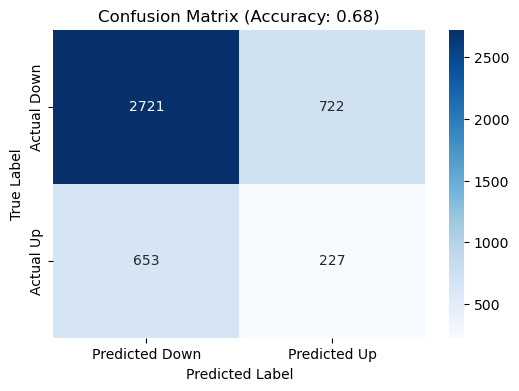

In [66]:
# confusion matrix display
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Down', 'Predicted Up'],
            yticklabels=['Actual Down', 'Actual Up'])
plt.title(f'Confusion Matrix (Accuracy: {acc:.2f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [67]:
# add prediction col to test df
df_test = test_data
df_test['prediction'] = y_pred
df_test

/var/folders/xf/h4xr85dn3d1d6gxjpf_rl78m0000gn/T/ipykernel_25117/4023905930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = y_pred


,Unnamed: 0,title,date,stock,Open,Close,finbert_sentiment_score,scaled_finbert_sentiment_score,next_close,price_change,up_or_down,stock_id,prediction
1098,852017.0,Merck Acquires Biocontrol,2017-01-04 13:32:00+00:00,MRK,60.500000,60.130001,6.044960,0.00,61.099998,0.969997,1,0,1
1097,852016.0,The Year's Biggest Healthcare Conference Comme...,2017-01-09 11:33:00+00:00,MRK,60.299999,61.099998,6.768095,0.02,61.099998,0.000000,0,0,1
1096,852015.0,"Incyte, Merck to Advance Clinical Development ...",2017-01-09 13:11:00+00:00,MRK,60.299999,61.099998,-12.737093,-0.49,61.099998,0.000000,0,0,1
1095,852014.0,"Exclusive: Ziopharm CEO Talks Partnerships, Ba...",2017-01-09 16:40:00+00:00,MRK,60.299999,61.099998,11.701741,0.15,61.099998,0.000000,0,0,1
1094,852013.0,Option Alert: Merck Jan 61.5 Calls Sweep: 745 ...,2017-01-09 18:25:00+00:00,MRK,60.299999,61.099998,3.442262,-0.07,59.919998,-1.180000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9120,929355.0,4 Technology Stocks Moving In Monday's Pre-Mar...,2019-12-23 12:46:00+00:00,NVDA,240.520004,238.820007,2.034345,-0.10,238.820007,0.000000,0,3,0
9119,929354.0,Stocks That Hit 52-Week Highs On Monday,2019-12-23 15:20:00+00:00,NVDA,240.520004,238.820007,6.237717,0.01,239.190002,0.369995,1,3,0
9116,929351.0,Here's How Much Investing $100 In Nvidia Stock...,2019-12-30 20:20:00+00:00,NVDA,235.990005,232.320007,8.258870,0.06,235.300003,2.979996,1,3,0
9115,929350.0,"Benchmark Maintains Buy on NVIDIA, Raises Pric...",2019-12-31 12:52:00+00:00,NVDA,230.899994,235.300003,1.238327,-0.13,235.300003,0.000000,0,3,0


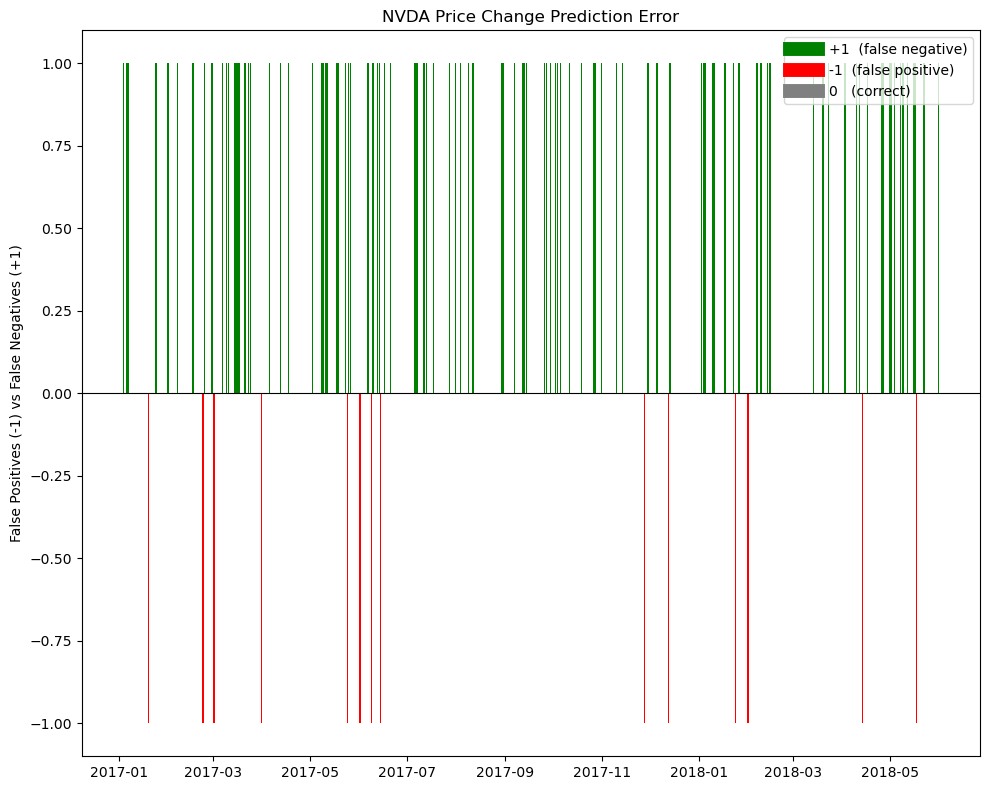

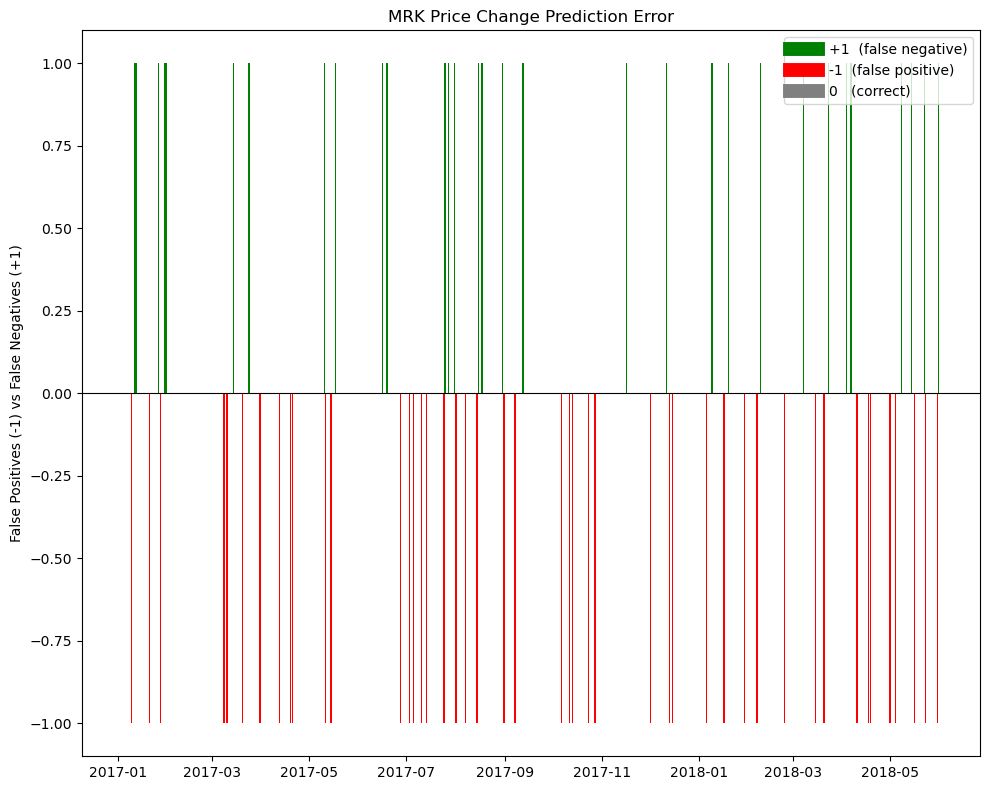

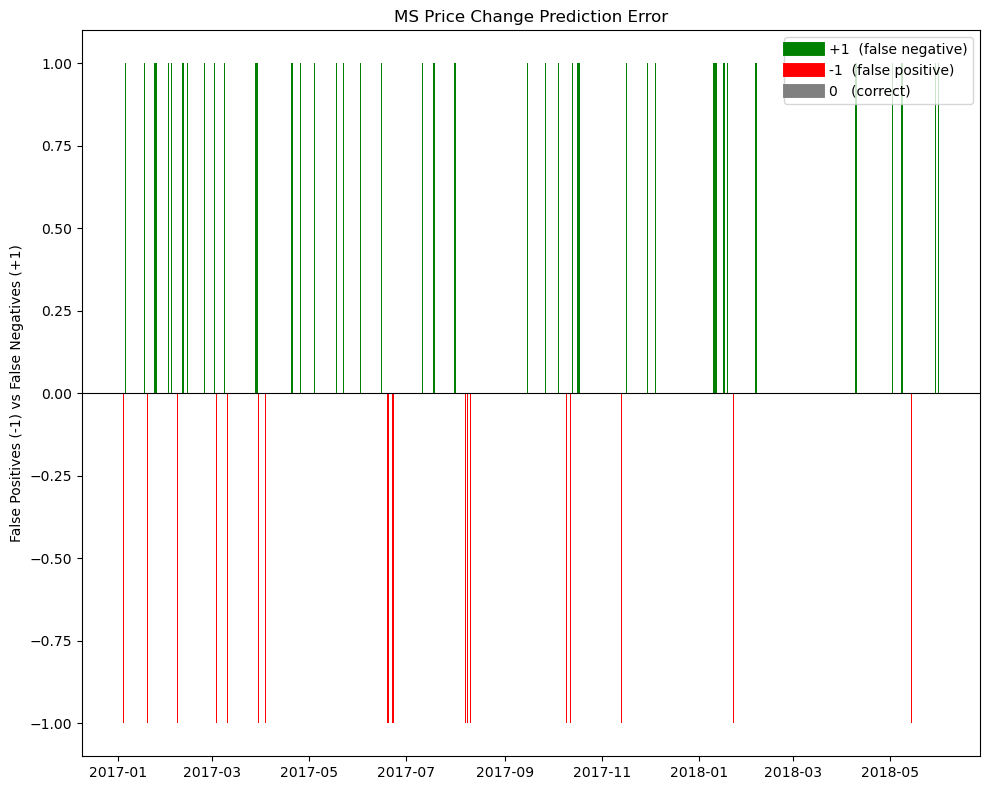

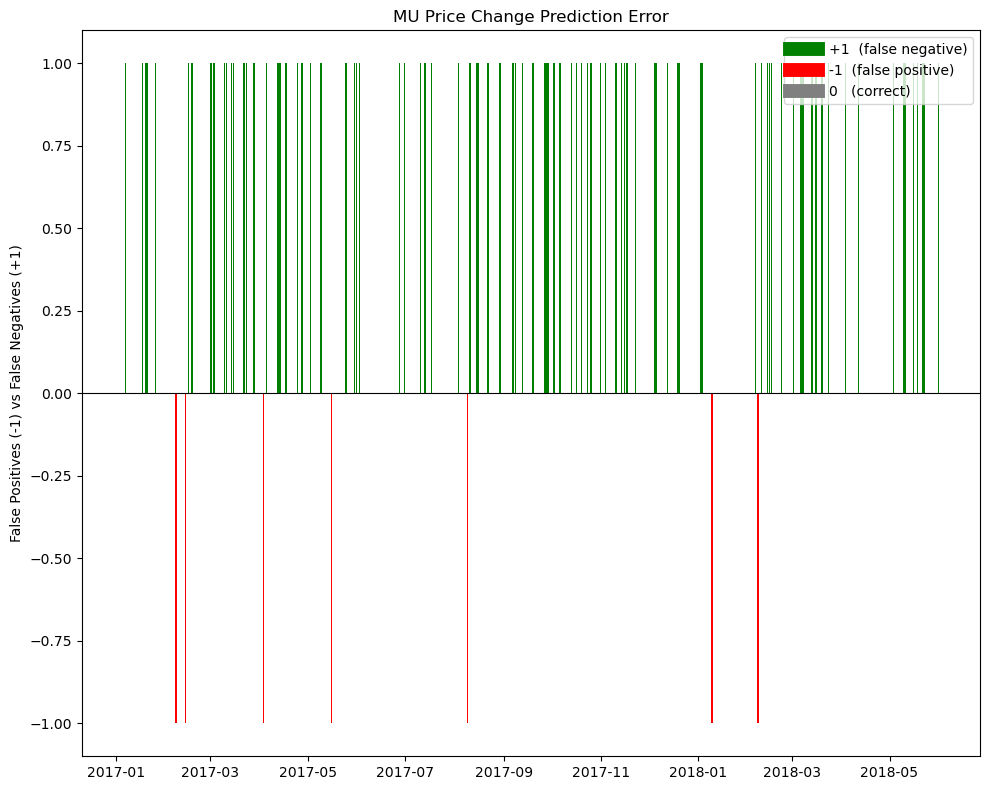

In [73]:
# plot per stock error lines for wrong predictions
cmap  = {0: 'grey', 1: 'green', -1: 'red'}
legend = [Line2D([0],[0], c='green', lw=10, label='+1  (false negative)'),
          Line2D([0],[0], c='red',   lw=10, label='-1  (false positive)'),
          Line2D([0],[0], c='grey',  lw=10, label='0   (correct)')]

# show the next year and a half of data from test set
split_date = pd.to_datetime('2018-06-01', utc=True)
plot_df = df_test[df_test['date'] < split_date]

for t in ['NVDA', 'MRK', 'MS', 'MU']:
    m = plot_df[(plot_df.stock == t) & plot_df.price_change.ne(0)].copy()
    if m.empty: continue
    m['diff'] = m.up_or_down - m.prediction
    plt.figure(figsize=(10, 8))
    plt.bar(m.date, m['diff'], color=m['diff'].map(cmap), width=.8)
    plt.axhline(0, c='k', lw=.8)
    plt.title(f'{t} Price Change Prediction Error')
    plt.ylabel('False Positives (-1) vs False Negatives (+1)')
    plt.legend(handles=legend, loc='upper right')
    plt.tight_layout()
    plt.show()


Prediction accuracy by stock:
stock
NVDA    0.774903
MU      0.768371
MS      0.632432
MRK     0.450515
dtype: float64


/var/folders/xf/h4xr85dn3d1d6gxjpf_rl78m0000gn/T/ipykernel_25117/426695538.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_test.groupby("stock").apply(lambda g: accuracy_score(g["up_or_down"], g["prediction"])).sort_values(ascending=False))
/var/folders/xf/h4xr85dn3d1d6gxjpf_rl78m0000gn/T/ipykernel_25117/426695538.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test.groupby("stock").appl

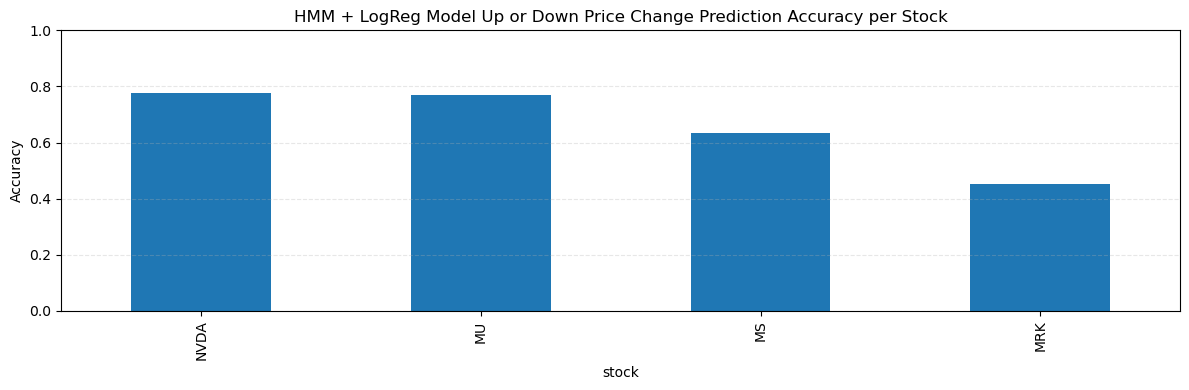

In [74]:
# plot chart with accuracy per stock

print("\nPrediction accuracy by stock:")
print(df_test.groupby("stock").apply(lambda g: accuracy_score(g["up_or_down"], g["prediction"])).sort_values(ascending=False))

plt.figure(figsize=(12, 4))
df_test.groupby("stock").apply(lambda g: accuracy_score(g["up_or_down"], g["prediction"])).sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("HMM + LogReg Model Up or Down Price Change Prediction Accuracy per Stock")
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

In [75]:
df_test.dropna(subset=['Close','prediction'], inplace=True)
df_test['Close'].fillna(method='ffill', inplace=True)

/var/folders/xf/h4xr85dn3d1d6gxjpf_rl78m0000gn/T/ipykernel_25117/2809086843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.dropna(subset=['Close','prediction'], inplace=True)
/var/folders/xf/h4xr85dn3d1d6gxjpf_rl78m0000gn/T/ipykernel_25117/2809086843.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Close'].fillna(metho

Demo : run the agent below to see which stock/trades would be best in this environment on the test data.

In [76]:
class TradingEnv(gym.Env):
    """
    trading environment with 4 actions:
    0 = flatten
    1 = hold
    2 = long
    3 = short

    Make a simulation of what it would be like for a reinforcement learning agent to perform trades, 
    selecting the best stock to trade after many iterations. 
    Uses the predictions from the HMM + LogReg Classifier to make guesses about price changes.
    """
    metadata, ACTIONS = {}, {0: 'flatten', 1: 'hold', 2: 'long', 3: 'short'}

    def __init__(self, df, init_cash=1_000_000, max_shares=10_000):
        super().__init__()
        self.df, self.init_cash, self.max_shares = df.reset_index(drop=True), init_cash, max_shares
        self.stock_name = str(self.df.iloc[0].get('stock', 'UnknownStock'))
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)
        self.reset()

        # cash + shares
    def _portfolio_val(self, price):
        return self.cash + self.shares * price

    def _obs(self):
        r = self.df.iloc[self.step_idx]
        return np.float32([r['prediction'], r['Close'], self.shares, self._portfolio_val(r['Close'])])

    def reset(self, *_):
        self.step_idx, self.shares, self.cash = 0, 0, self.init_cash
        return self._obs()

    def step(self, action: int):
        price = self.df.iloc[self.step_idx]['Close']
        port_before = self._portfolio_val(price)

        # 1 = hold
        if action:
            # flatten every non hold first
            self.cash += self.shares * price
            self.shares = 0
            # long
            if action == 2:
                self.shares = min(self.max_shares, int(self.cash // price))
                self.cash -= self.shares * price
            # short
            elif action == 3:
                self.shares = -self.max_shares
                self.cash += -self.shares * price

        # move to next step
        self.step_idx += 1
        done = self.step_idx >= len(self.df) - 1
        next_price = self.df.iloc[self.step_idx]['Close'] if not done else price
        # adjust portfolio value
        reward = self._portfolio_val(next_price) - port_before

        return (self._obs() if not done else
                np.float32([0, 0, 0, self._portfolio_val(next_price)])), reward, done, {}

def train_and_eval(df, steps=5_000, name="Agent"):
    # train and evaluate 30 agents
    env = DummyVecEnv([lambda: TradingEnv(df)])
    model = PPO('MlpPolicy', env, verbose=0).learn(total_timesteps=steps)

    # set up environment initial
    eval_env, obs, done = TradingEnv(df), None, False
    obs, hist = eval_env.reset(), []

    # train through evaluation of portfolio
    while not done:
        action = int(model.predict(obs, deterministic=True)[0])
        date, price = df.iloc[eval_env.step_idx][['date', 'Close']]
        port_before = eval_env._portfolio_val(price)

        # perform step and evaluate
        obs, reward, done, _ = eval_env.step(action)
        # append trades, actions, rewards
        hist.append(
            dict(step=eval_env.step_idx, date=date, price=price,
                 action=TradingEnv.ACTIONS[action], reward=reward,
                 port_val=port_before)
        )

    # get final portfolio value
    final_val = eval_env._portfolio_val(df.iloc[eval_env.step_idx]['Close'])
    return dict(name=name, stock=eval_env.stock_name, history=hist, final_value=final_val)

agent_names = [f"agent{i}" for i in range(1, 30)]
results = [train_and_eval(df_test, name=n) for n in agent_names]
best = max(results, key=lambda x: x['final_value'])

print(f"best PPO agent: {best['name']} - stock: {best['stock']} - "
      f"final portfolio: {best['final_value']:.2f}\n")

for h in best['history']:
    print(f"Step {h['step']} | {h['date']} | {h['action']} | "
          f"Price={h['price']} | Port={h['port_val']} | Reward={h['reward']}")


/opt/anaconda3/envs/luci/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/luci/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/luci/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your envir

best PPO agent: agent1 - stock: MRK - final portfolio: 2751700.02

Step 1 | 2017-01-04 13:32:00+00:00 | long | Price=60.130001068115234 | Port=1000000.0 | Reward=9699.974060058594
Step 2 | 2017-01-09 11:33:00+00:00 | long | Price=61.099998474121094 | Port=1009699.9740600586 | Reward=0.0
Step 3 | 2017-01-09 13:11:00+00:00 | long | Price=61.099998474121094 | Port=1009699.9740600586 | Reward=0.0
Step 4 | 2017-01-09 16:40:00+00:00 | long | Price=61.099998474121094 | Port=1009699.9740600586 | Reward=0.0
Step 5 | 2017-01-09 18:25:00+00:00 | long | Price=61.099998474121094 | Port=1009699.9740600586 | Reward=-11800.003051757812
Step 6 | 2017-01-10 21:06:00+00:00 | long | Price=59.91999816894531 | Port=997899.9710083008 | Reward=0.0
Step 7 | 2017-01-10 21:07:00+00:00 | long | Price=59.91999816894531 | Port=997899.9710083008 | Reward=0.0
Step 8 | 2017-01-10 22:12:00+00:00 | long | Price=59.91999816894531 | Port=997899.9710083008 | Reward=17100.02899169922
Step 9 | 2017-01-11 11:45:00+00:00 | lon

In [77]:
# unit test for trading environment class
unit_df = pd.DataFrame({"prediction": [1.0, 0.0, 1.0],
                        "Close": [100.0, 120.0, 110.0],
                        "date": pd.date_range("2025-01-01", periods=3),
                        "stock": ["test", "test", "test"]})
# try reset
def test_reset():
    env = TradingEnv(unit_df, init_cash=1_000, max_shares=10)
    obs = env.reset()

    assert obs.shape == (4,)
    assert np.isclose(obs[1], 100.0)
    assert env.shares == 0
    assert env.cash == 1_000
# hold at step
def test_step_hold():
    env = TradingEnv(unit_df, init_cash=1_000, max_shares=10)
    _, reward, done, _ = env.step(1)

    assert not done
    assert env.shares == 0
    assert env.cash == 1_000
    assert np.isclose(reward, 0.0)
# go long
def test_long_all():
    env = TradingEnv(unit_df, init_cash=1_000, max_shares=10)
    obs, reward, done, _ = env.step(2)

    assert env.shares == 10
    assert env.cash == 0
    assert np.isclose(reward, 200.0)
    assert not done

    expected = np.float32([0.0, 120.0, 10])
    np.testing.assert_array_almost_equal(obs[:3], expected)

for fn in [test_reset, test_step_hold, test_long_all]:
    fn()
    print(f"pass")

print("\nall tests passed")

pass
pass
pass

all tests passed
